# Summary

This notebook conducts what's known as an *ETL* pipeline. ETL stand for *Extract-Transform-Load*. Data science projects almost always begin by deciding what data we need to conduct an analysis, what transformations need to be performed on the data, and how the data should be stored for efficient manipulation/joining.

In this notebook we will:
- Pull down several raw datasets contained on the [NHANES website](https://en.wikipedia.org/wiki/Hierarchical_Data_Format). We'll do this using a combination of bash and pandas: bash for the datasets that need to be unzipped, pandas for those we can read directly from source.
- Store the raw SAS format data as something more reasonable and modern (I'm going to use [HDF format](https://github.com/wesm/feather) which is a super fast binary data representation, but feel free to play around with .h5 or another format as you see fit)
- Do some initial QC checks on the data to ensure everything looks reasonable.

# Learning Objectives

After completing this module you should be able to do the following:

1. Use pandas to pull raw data from source
2. Use ```wget``` and ```unzip``` to pull in data that can't be read directly from source via pandas
3. Understand why data compression is important, and how to downcast datatypes for efficient memory allocation
4. Construct basic visualization tools for checking data quality
5. Understand what metadata is, and build some tools for efficiently binding data with metadata
6. Understand how to join together two relational tables

# Initialize

Below are the external dependencies this notebook depends on to function. If you don't have these installed you can install them using pip or conda- whichever you typically use as your package manager.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import utils # Utility functions we will use
import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('max.rows', 100)
pd.set_option('max.columns', 100)

data_dir = '/Users/bbradshaw/nhanes/' # Change this location to the path where you would like your data saved to
hdf_path = 'nhanes.h5' # Path to hdf store we will create later

# Download, unzip, and save raw physical activity monitor data.

The raw PAX data is zipped due to its size and can't be read directly into pandas. We use the following steps to get it into a more manageable format:
1. Download the data using the bash command ```wget```
2. Unzip the downlaoded data using the bash command ```unzip```
3. Read the data into pandas, and downcast data types to save on memory. The machine we are using has 32G of RAM, if your machine has less you may have issues with this step. If that's the case we suggest you don't actually run this portion of the ETL pipeline but rather use the ```nhanes.h5``` store we have written out and supplied to you.

In [3]:
###############################################################
# RUN THIS BLOCK ONLY IF YOU WANT TO RECREATE THE ETL PROCESS # 
# OTHERWISE READ THE PREPROCESSED FILE - IT TAKES FOREVER     #
# AND ISN'T THAT INTERESTING                                  #
###############################################################

! wget https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/PAXRAW_D.ZIP
! mv PAXRAW_D.ZIP {data_dir}
! unzip {data_dir}PAXRAW_D.ZIP -d {data_dir}

--2018-04-16 14:56:25--  https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/PAXRAW_D.ZIP
Resolving wwwn.cdc.gov... 198.246.102.39
Connecting to wwwn.cdc.gov|198.246.102.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470990068 (449M) [application/x-zip-compressed]
Saving to: ‘PAXRAW_D.ZIP’

PAXRAW_D.ZIP        100%[===================>] 449.17M   925KB/s    in 9m 58s  

2018-04-16 15:06:24 (769 KB/s) - ‘PAXRAW_D.ZIP’ saved [470990068/470990068]

Archive:  /Users/bbradshaw/nhanes/PAXRAW_D.ZIP
  inflating: /Users/bbradshaw/nhanes/paxraw_d.xpt  


In [4]:
#############################################################
# AGAIN - ONLY RUN THIS BLOCK IF YOU ARE CURIOUS, IT TAKES  # 
# A LONG TIME, AND IT'S EASIER/FASTER TO USE THE HDF STORE  #
# WE PROVIDE THAT HAS ALREADY PROCESSED THE DATA            #
#############################################################
! python -m xport {data_dir}paxraw_d.xpt > {data_dir}paxraw_d.csv

In [14]:
# Using the default float types is extremely memory intensive given the number of rows we are dealing with. 
# Let's downcast each column appropriately.

type_map = {
    'SEQN': 'object',
    'PAXSTAT': np.int8,
    'PAXCAL': np.int8,
    'PAXDAY': np.int8,
    'PAXHOUR': np.int16,
    'PAXMINUT': np.int16,
    'PAXINTEN': np.int16,
    'PAXSTEP': np.float32,
    'PAXN': np.int16
}

In [15]:
# Read the csv file we just created into memory in order to downcast
# NOTE: Reading in the raw csv requires quite a bit of memory before downcast
pax_path = 'paxraw_d.csv'
%time pax_raw = pd.read_csv(os.path.join(data_dir, pax_path), dtype=type_map)

CPU times: user 1min 37s, sys: 8.36 s, total: 1min 45s
Wall time: 1min 51s


In [10]:
# pythonize column names
pax_raw.columns = [x.lower() for x in pax_raw.columns]

In [11]:
# Display dataframe types and usage statistics
pax_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74874095 entries, 0 to 74874094
Data columns (total 9 columns):
seqn        object
paxstat     int8
paxcal      int8
paxday      int8
paxn        int16
paxhour     int16
paxminut    int16
paxinten    int16
paxstep     float32
dtypes: float32(1), int16(4), int8(3), object(1)
memory usage: 1.6+ GB


You can see that downcasting our types saved us a *significant* amount of memory (prior to specifying the datatypes the datframe was consuming 8+ GB of memory). We manually inferred the best datatypes, but for datasets with larger numbers of columns it would be more efficient to automatically infer the datatypes.

We will store our data in an HDF store. An HDF store is very similar to a database like SQLite or PostgreSQL in that you can store several tables under one store. Additionally, HDF preserves python data types between write and read- which is a very nice property for dates or in our case memory savings. You can see in the code block below that we can list the table keys stored in our HDF store. Finally, I/O operations are *much* faster than file formats such as csv, sometimes by as much as 100x.

In [13]:
pax_raw.to_hdf(os.path.join(data_dir, hdf_path), 'pax_raw')

# Read other NHANES tables directly from source

The other tables aren't compressed- they are simply raw .XPT files written out via SAS. We can read directly from source. There are a TON of interesting files on the NHANES website- from disease state questionnaires to physical activity questionnaires. We have linked a few interesting tables below, we will leave it to you to add the rest.

In [14]:
# In order to grab tables from the CDC NHANES website, simply add a table alias to the dictionary below,
# and then reference the table link address as the corresponding key value. The read_sas_write_feather
# function in utils will then read each sas file and write it to write_dir in feather format using 
# the alias as the file name

source_paths = {
    'medical_conditions_questionnaire': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/MCQ_D.XPT',
    'weight_history_questionnaire': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/WHQ_D.XPT',
    'demographics_with_sample_weights': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/DEMO_D.XPT'
}

In order to optimize I/O, and keep all of our data in one place, we'll download each of the raw datasets we are interested in into memory, then save it to our already created HDF store.

In [29]:
utils.read_sas_write_hdf(source_paths, data_dir, 'nhanes.h5')

/Users/bbradshaw/venv3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block1_values] [items->['seqn']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [30]:
with pd.HDFStore(os.path.join(data_dir, 'nhanes.h5')) as hdf:
    print(hdf.keys())

['/demographics_with_sample_weights', '/medical_conditions_questionnaire', '/pax_raw', '/weight_history_questionnaire']


Looks like all requested tables made it safely into our data store!

## Exercise: Find and read the physical activity questionnaire

Find the raw SAS file on the 2005-2006 NHANES website that corresponds to the physical activity questionnaire. Use the function ```utils.read_sas_write_hdf()``` to download this file and write it into the HDF store that contains the other tables we already downloaded above.

In [27]:
######################
# YOUR SOLUTION HERE #
######################

## Solution: Find and read the physical activity questionnaire

In [ ]:
append_paths = {
    'physical_activity_questionnaire': 'https://wwwn.cdc.gov/Nchs/Nhanes/2005-2006/PAQ_D.XPT'
}

In [ ]:
utils.read_sas_write_hdf(source_paths, data_dir, 'nhanes.h5', downcast=False, verbose=False)

# Initial QC of physical activity data

In order to verify that the raw physical activity data looks reasonable, we will create a some tools that will allow us to quickly visualize the time series that correspond to each user-day's walking patterns. There are a few good reasons for doing this:
1. This will allow us to infer if our preprocessing worked correctly
2. It will allow us to identify idiosyncracies in the raw data itself
3. It will help us better understand what sorts of features could be useful for various prediction or inference problems

In [106]:
%time pax_raw = pd.read_hdf(os.path.join(data_dir, hdf_path), 'pax_raw')

CPU times: user 4.14 s, sys: 6.86 s, total: 11 s
Wall time: 14.3 s


Note the incredible increase in speed when we read the accelerometer data from the hdf store rather than from the csv file: from a wall time of 117 seconds to a wall time of 12.3 seconds!

In [107]:
# Add a "minute of day" column as a plotting index
pax_raw['minute_of_day'] = pax_raw.paxhour*60 + pax_raw.paxminut
pax_raw.head()

,seqn,paxstat,paxcal,paxday,paxn,paxhour,paxminut,paxinten,paxstep,minute_of_day
0,31128.0,1,1,1,1,0,0,166,4.0,0
1,31128.0,1,1,1,2,0,1,27,0.0,1
2,31128.0,1,1,1,3,0,2,0,0.0,2
3,31128.0,1,1,1,4,0,3,276,4.0,3
4,31128.0,1,1,1,5,0,4,0,0.0,4


In [24]:
# Take the raw data and filter out a single person just to check if the data looks reasonable.
test_id = '31128.0'
pax_sample = pax_raw[pax_raw.seqn==test_id].copy()

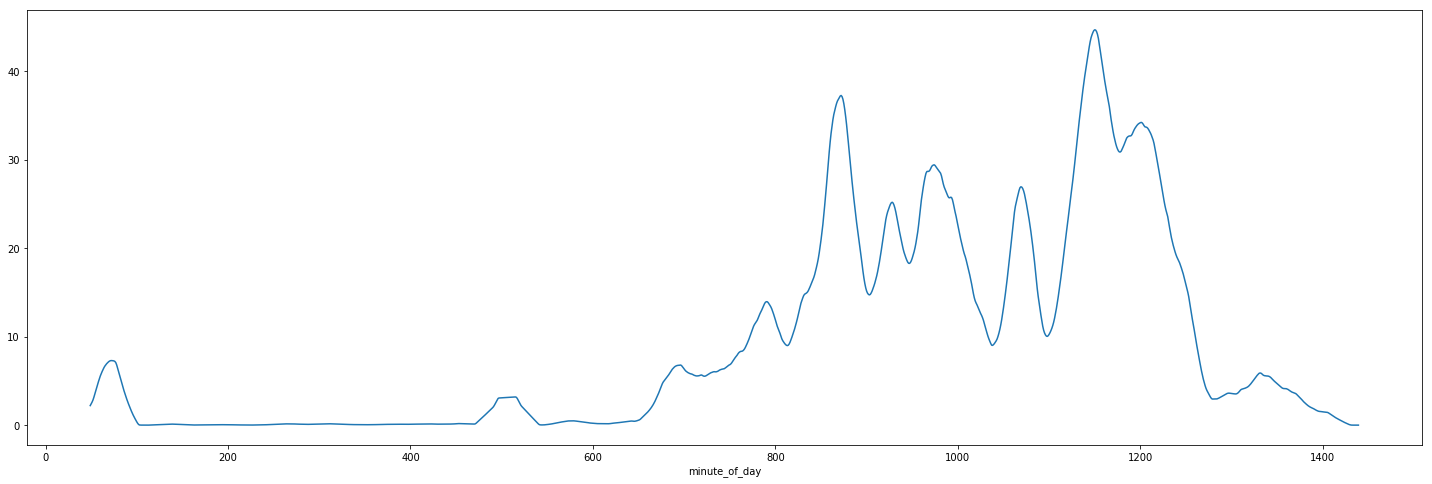

In [26]:
# Plot the 30-minute rolling walk step series for our sampled user over day 1
pax_sample[pax_sample.paxday==1].set_index('minute_of_day').paxstep.rolling(window=50, win_type='triang').mean().plot(figsize=(25,8))

We just did some hand coding to plot a sngle user-day, but what if we wanted to explore *many* user days? It would be helpful to build a tool that would allow us to quickly look at different days and different users in our data.

## Exercise: Plotting user day series

Using the example code above, define a function ```plot_user_steps()``` that takes 4 arguments as input and plots a specific user's rolling walk step plot simialr to the plot shown above. The function's arguments should be:
1. ```pax_df``` (pandas dataframe) The physical activity dataframe
2. ```seqn_id``` (str) The unique study participant id
3. ```day_of_study``` (int) The day of the study to plot
4. ```window_len``` (int) The window length to use for the moving average.

The function should then plot the rolling walk series for a specific user, for a specific day. As a bonus, build in functionality so that passing ```None``` to the parameter ```seqn_id``` will default to choosing a random id from the set of seqn ids and using that to create the plot.

**Side Note: Building Data Science Tools**
A lot of what practicing data scientists do on a daily basis revolves around building tools that solve specific problems pertaining to an analysis. In fact, some may argue that's what seperates a data scientist from your everyday analyst. During this module we really want to encourage you to build tools that make analysis scale. In the process you may even find that it can be very fun and rewarding to create a useful suite of analysis tools to speed up your workflow!

In [10]:
######################
# YOUR SOLUTION HERE #
######################

## Solution: Plotting user day series

We wrote a little snippet of code that implements the solution above. If you are curious how we did it, take a look in the ```utils``` folder that was imported at the top of the notebook.

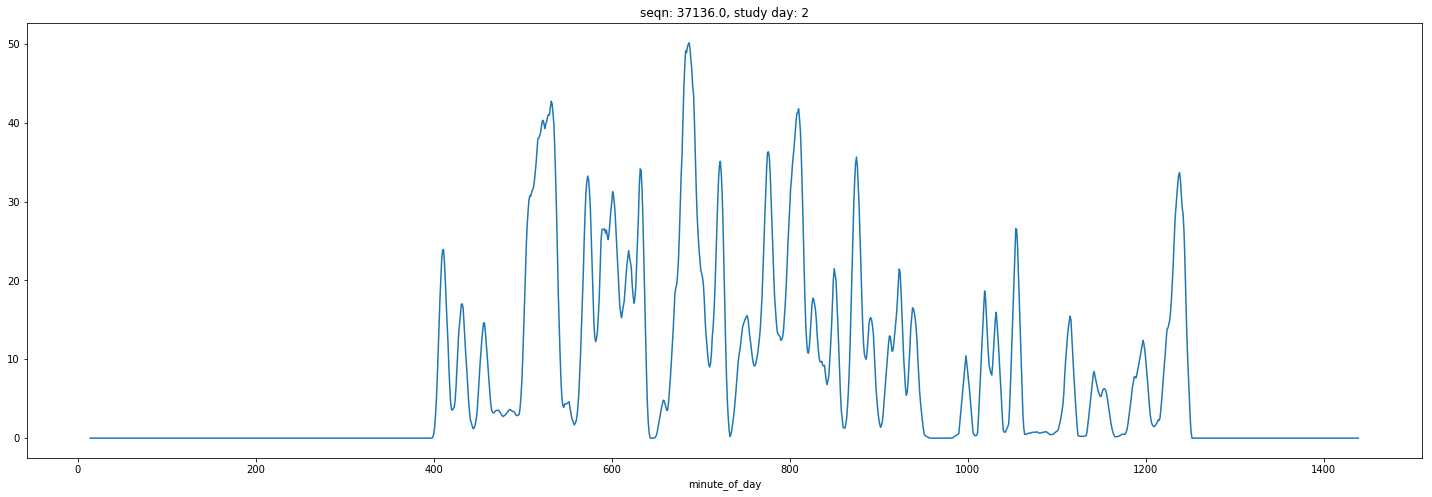

In [34]:
# Look in the utils library to see how we implemented the solution.
utils.plot_user_steps(pax_raw, None, 2, 15)

# Cleaning the raw PAQ data

IoT data can be pretty messy: often times we have long sequences of missing values or we find that sensor malfunctions lead to large outliers in a signal. In order to make our lives a bit easier, we are going to do some initial quality control (QC) on the data. There are a few things we should consider:

1. The paxcal column indicates whether a person's monitor was calibrated or not. In order to ensure we only conduct analysis on valid data, we should discard observations where the monitor was not calibrated.
2. Participants *should* have worn the device during all waking hours. It's doubtful as to whether participants complied with this- so we need to figure out a way to check.
3. Participants were expected to wear the device for 7 days, however many didn't. We are going to restrict our sample to only those participants who had at least 4 valid days.

## Cleaning Part I: Filtering miscalibrated devices

The ```paxcal``` column indicates whether a participant's device was calibrated during a particular period of the study. Let's do some investigation in order to identify users with a high percentage of miscalibrated time

In [108]:
# Map values to something more reasonable
cal_map = {1:1, 2:0}
pax_raw['paxcal'] = pax_raw.paxcal.map(cal_map)

In [54]:
# Check proportion of calibrated minutes vs not- 1 id calibrated, else 0
pax_raw.paxcal.value_counts() / len(pax_raw)

1    0.950388
0    0.049612
Name: paxcal, dtype: float64

In [57]:
# Check if users could be in calibration for only some days
pax_raw.groupby('seqn').paxcal.mean().value_counts()

1    7086
0     369
Name: paxcal, dtype: int64

It appears about 5% of user didn't have their device calibrated. For these folks, we will simply exclude them from the analysis.

In [109]:
pax_raw = pax_raw[pax_raw.paxcal==1].copy() # Keep only users with a calibrated device
pax_raw.drop(columns='paxcal', inplace=True) # Drop the calibration column, we no longer need it

As a first check let's look at the distribution of steps/minute.

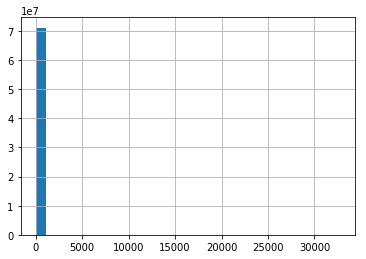

In [61]:
pax_raw.paxstep.hist(bins=30)

The above histogram is pretty worthless. What is going on here? **Stop and think for a moment. What should the distribution of walk steps look like?** Most of our days are spent *seated* meaning that we record zero steps during those minutes. A normal walking pace is around 100 steps per minute. If you are really running you may record 300+ steps per minute. So we expect the majority of the step density to be clustered at zero, perhaps like an exponential distribution. 

As a first invstigation, let's restrict our data to only minutes where observed steps are less than 300 and check out what the distrubution looks like.

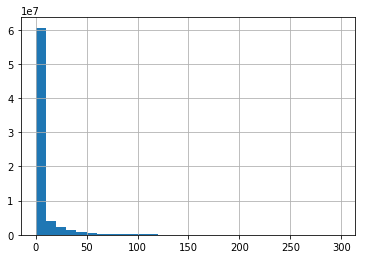

In [67]:
step_threshold = 300
pax_raw[pax_raw.paxstep<step_threshold].paxstep.hist(bins=30)

Now the histogram is more infomative. Indeed, this confirms our prior: most minutes are spent seated, a moderately sized proportion are spent walking, and very few are spent at high intensities. Moreover, we suspect that some large outliers may be influencing the data. Let's investigate.

In [62]:
pax_raw.paxstep.describe()

count    7.115940e+07
mean     1.623266e+01
std      5.465219e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      3.276700e+04
Name: paxstep, dtype: float64

The max value is suspicious: 32,670 steps recorded in a minute? That seems superhuman! Indeed, too good to be true. It appears that the accelerometer that logs steps sometimes produces large outliers that are orders of magnitude larger than normal observations. This is a problem we will need to fix. In order to do so, we should identify a *reasonable threshold that meets the common sense test*. What is the common sense test? While it isn't a statistical test, it may actually be the most important test to master in data science. We simply need to ask ourselves, what is a reasonable number of steps $s$ for which it would be unlikely that a sensor reading above $s$ is legitimate?

In [69]:
pct_outliers = len(pax_raw[pax_raw.paxstep>step_threshold]) / len(pax_raw)*100
print(f'Proportion of minutes with > {step_threshold} steps: {pct_outliers}')

Proportion of minutes with > 300 steps: 0.18375631293435898


So we have chosen a "reasonable" threshold of 300 steps/minute. Now what? We have a few options. We could:
- Drop the observations that are above our threshold (this is not ideal given that we are dealing with time series data)
- Set these observations to a null value, and then fill them using some yet to be defined strategy
- "Winsorize them" meaning we set them to a fixed percentile value drawn from the distribution of steps

Each of these strategies forces us to make assumptions about the data that may not be true. It's up to us as the practitioner to decide which methods will help us best accomplish the goal at hand- whether that is inference or prediction. In a prediction setting, you could actually determine the "best" strategy using a data driven approach via cross validation. For now (for simplicity's sake), let's use the winsorize method with a twist: for each participant we will find the 99th percentile of their walk steps and use that value to fill values above 300.

In [99]:
cut_pctile = 0.99 # Set our fill value to be the 99th percentile of each user's step distribution
part_fill_vals = pax_raw.groupby('seqn').paxstep.quantile(cut_pctile).reset_index() # Compute quantiles

In [110]:
part_fill_vals.rename(columns={'paxstep': 'fill_values'}, inplace=True)

In [111]:
# Now some tricky business to fill the correct values

In [93]:
# Check that the largest observed value is <= step threshold
assert pax_raw.paxstep.max() <= step_threshold

# Joining Data

The NHANES dataset has **A LOT** of tables. These tables are *relational* in structure meaning that their is a heirarchical structure that relates one set of data to another. In the NHANES dataset the *person level identifier* is the ```seqn``` number as you have already seen above. For some tables each row corresponds to exactly one ```seqn``` number. For other tables (like the raw activity data we have already worked with) there is a *one to many* mapping between ```seqn``` identifiers and row numbers, meaning that one ```seqn``` number corresponds to multiple input rows. Indeed for the ```pax_raw``` dataset we already worked with above, each person is associated with *thousands* of rows corresponding to each minute of a day in which the person wore an activity monitor.

For this next section we will ensure that we can join together data from the various tables we pulled. This will be important for creating new interesting features later on, both for prediction and inference tasks, as we'll need to put together a feature matrix that combines data from multiple tables within the NHANES database.

## Example: Joining Datasets

As an example let's join together two of the tables we pulled in above that should now exist in your local HDF store:

- Participant demographics
- Physical activity data (we already pulled this in above)

There is a 1:1 correspondence between these two tables. For this join, we will do what is known as an *inner join*. This means that we will specify a join key that exists in both sets, and *only* join those keys that exist in the intersection of the two key sets. For more information on the different types of joins check out [this resource](https://www.w3schools.com/sql/sql_join.asp).

In [13]:
demo_df = pd.read_hdf(os.path.join(data_dir, hdf_path), 'demographics_with_sample_weights')

# Let's checkout what's in this dataframe
demo_df.head()

,seqn,sddsrvyr,ridstatr,ridexmon,riagendr,ridageyr,ridagemn,ridageex,ridreth1,dmqmilit,dmdborn,dmdcitzn,dmdyrsus,dmdeduc3,dmdeduc2,dmdschol,dmdmartl,dmdhhsiz,dmdfmsiz,indhhinc,indfminc,indfmpir,ridexprg,dmdhrgnd,dmdhrage,dmdhrbrn,dmdhredu,dmdhrmar,dmdhsedu,sialang,siaproxy,siaintrp,fialang,fiaproxy,fiaintrp,mialang,miaproxy,miaintrp,aialang,wtint2yr,wtmec2yr,sdmvpsu,sdmvstra
0,31127,4.0,2.0,2.0,1.0,5.397605e-79,11.0,12.0,3.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,4.0,0.75,NaN,2.0,21.0,1.0,3.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,6434.950248,6571.396373,2.0,44.0
1,31128,4.0,2.0,1.0,2.0,1.100000e+01,132.0,132.0,4.0,NaN,1.0,1.0,NaN,4.0,NaN,1.0,NaN,7.0,6.0,8.0,5.0,0.77,2.0,1.0,47.0,1.0,2.0,NaN,NaN,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,9081.700761,8987.041810,1.0,52.0
2,31129,4.0,2.0,2.0,1.0,1.500000e+01,189.0,190.0,4.0,NaN,1.0,1.0,NaN,10.0,NaN,1.0,5.0,6.0,6.0,10.0,10.0,2.71,NaN,1.0,41.0,1.0,4.0,1.0,4.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,5316.895215,5586.719481,1.0,51.0
3,31130,4.0,2.0,2.0,2.0,8.500000e+01,NaN,NaN,3.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,2.0,1.0,1.0,4.0,4.0,1.99,NaN,2.0,85.0,1.0,4.0,2.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,29960.839509,34030.994786,2.0,46.0
4,31131,4.0,2.0,2.0,2.0,4.400000e+01,535.0,536.0,4.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,1.0,4.0,4.0,11.0,11.0,4.65,2.0,1.0,36.0,1.0,5.0,1.0,4.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,26457.708180,26770.584605,1.0,48.0


What in the world? What are all the cryptic column names?? Well, the CDC has chosen somewhat unhelpful names that map to demographic characteristics of participants. We *could* go to the website that lists the variable names and keep track of them. However, if we are clever there might be a better way. . . .The pandas library makes it esy to scrape tables via a url. All we need is the url where the table is located, as well as the index of the xml blob we are interested in.

In [10]:
demo_metadata_url = 'https://wwwn.cdc.gov/nchs/nhanes/search/variablelist.aspx?Component=Demographics&CycleBeginYear=2005'
idx = 1 # I looked up the blob I was interested in in advance

demo_metadata = pd.read_html(demo_metadata_url)[idx]

demo_metadata.head()

In [20]:
demo_metadata['Data File Name'].unique()

array(['CDEMO_AD', 'DEMO_D', 'N0506_GE', 'LDEMO_AD'], dtype=object)

Nice! Now we have a dataframe with two columns of interest: ```Variable Name``` and ```Variable Description```. We could remap the column names to human readable. I'll leave that as an exercise for you if you feel inclined. 

**Note: this metadata DataFrame has metadata from more files than just the `DEMO_D` data we are currently working with, so it might make sense to filter the rest out.*

## Exercise: Create questionnaire metadata table

For this exercise replicate the process we did above for the questionnaire metadata. You will need:
- The url on the 2005 NHANES website where the questionnaire metadata is stored
- The index of the xml blob corresponding to the metadata table

Save the metadata table in a new dataframe called ```quest_metadata```.

## Solution: Create questionnaire metadata table

In [17]:
quest_metadata_url = 'https://wwwn.cdc.gov/nchs/nhanes/search/variablelist.aspx?Component=Questionnaire&CycleBeginYear=2005'
quest_meta_data = pd.read_html(quest_metadata_url)[1]

In [21]:
quest_meta_data.head()

,Variable Name,Variable Description,Data File Name,Data File Description,Begin Year,EndYear,Component,Use Constraints
0,SEQN,Respondent sequence number.,ACQ_D,Acculturation,2005,2006,Questionnaire,None
1,ACD010A,What language(s) {do you/does SP} usually spea...,ACQ_D,Acculturation,2005,2006,Questionnaire,None
2,ACD010B,What language(s) {do you/does SP} usually spea...,ACQ_D,Acculturation,2005,2006,Questionnaire,None
3,ACD010C,What language(s) {do you/does SP} usually spea...,ACQ_D,Acculturation,2005,2006,Questionnaire,None
4,ACD040,Now I'm going to ask you about language use. W...,ACQ_D,Acculturation,2005,2006,Questionnaire,None
